
 Training Model 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/300
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 54295363584.0000 - mae: 205275.6719 - val_loss: 45652959232.0000 - val_mae: 186197.7969 - learning_rate: 0.0010
Epoch 2/300
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 55641137152.0000 - mae: 207598.8594 - val_loss: 45511647232.0000 - val_mae: 185840.1094 - learning_rate: 0.0010
Epoch 3/300
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 54572511232.0000 - mae: 204062.9844 - val_loss: 44694609920.0000 - val_mae: 183756.8594 - learning_rate: 0.0010
Epoch 4/300
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 49257009152.0000 - mae: 194087.2812 - val_loss: 42099240960.0000 - val_mae: 177084.4062 - learning_rate: 0.0010
Epoch 5/300
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 44964855808.0000 - mae: 180756.3438 - val_loss: 36563607552.0000 - val_mae: 161271.2344 - learning_rate: 0.0010
Epoch 6/300
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 32202629120.0000 - mae: 147540.6719 - val_loss: 28488589312.0000 - val_mae: 135530.

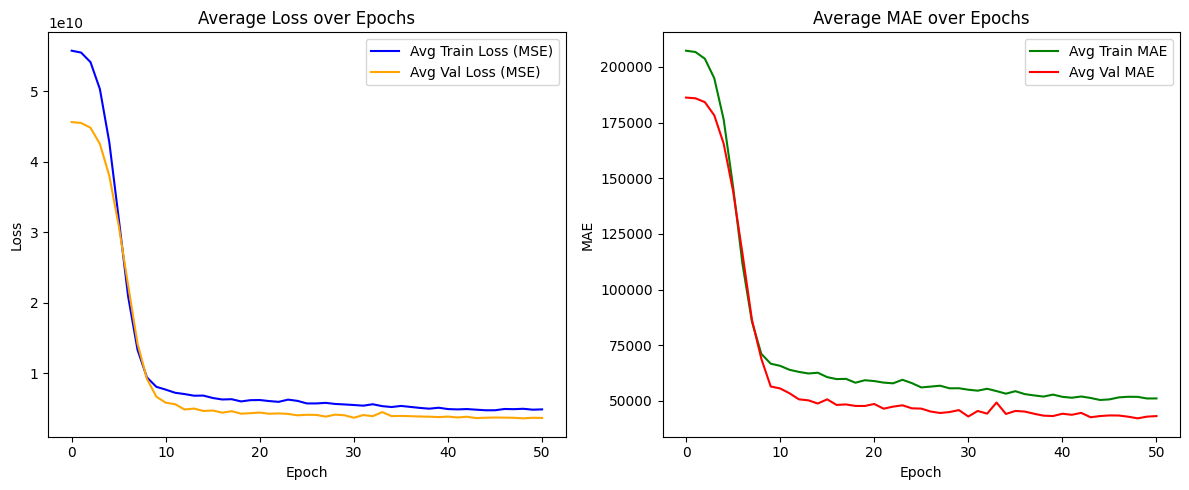

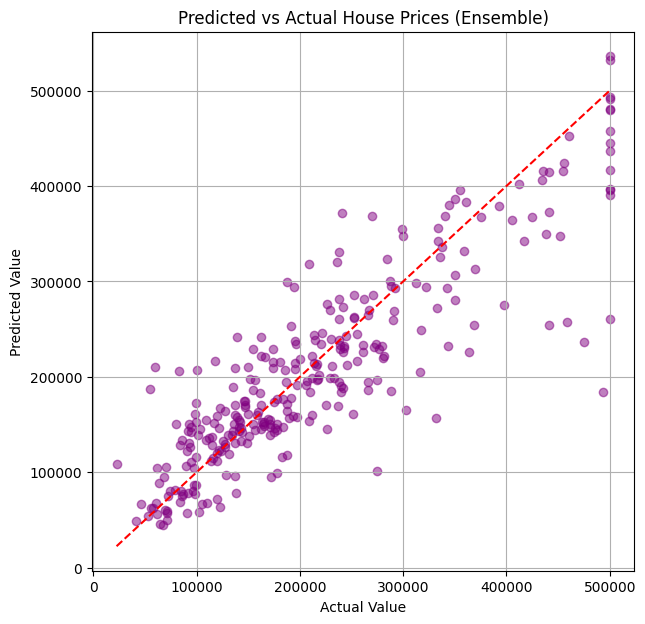

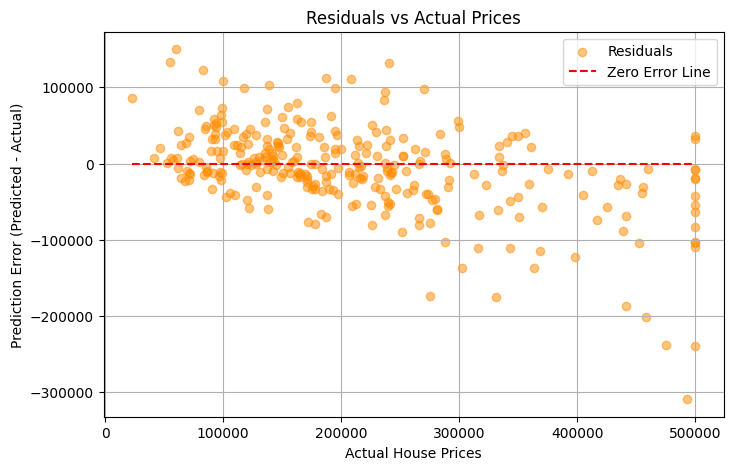

In [ ]:
# STEP 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam

# STEP 2: Load the Dataset
data = pd.read_csv('/content/drive/MyDrive/california_housing_test_1.csv')

# STEP 3: Preprocess the Data
X = data.iloc[:, 0:8].values  # input features
y = data.iloc[:, 8].values    # target column

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# STEP 4: Build the Model Function
def build_model():
    model = Sequential()
    model.add(Dense(256, input_shape=(8,)))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.01))

    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.01))

    model.add(Dense(1))

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

#  STEP 5: Train 3 Models and Store Predictions + Histories
models = []
predictions = []
all_histories = []

for i in range(3):
    print(f"\n Training Model {i+1}/3")
    model = build_model()

    checkpoint_path = f"best_model_{i}.keras"
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)
    early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=300,
        batch_size=32,
        callbacks=[early_stop, reduce_lr, checkpoint],
        verbose=1
    )

    all_histories.append(history.history)

    model = load_model(checkpoint_path)
    models.append(model)
    predictions.append(model.predict(X_test).flatten())

#  STEP 6: Ensemble Predictions (Average)
final_prediction = np.mean(predictions, axis=0)

#  STEP 7: Evaluate Final Ensemble
mse = mean_squared_error(y_test, final_prediction)
mae = mean_absolute_error(y_test, final_prediction)
r2 = r2_score(y_test, final_prediction)

print(f"\n Final Ensemble Evaluation:")
print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# STEP 8: Custom Accuracy
threshold = 50000
accurate_predictions = np.abs(final_prediction - y_test) < threshold
custom_accuracy = np.mean(accurate_predictions)
print(f"Custom Regression Accuracy (±${threshold}): {custom_accuracy * 100:.2f}%")

# STEP 9: Plot Avg Loss and MAE from 3 Runs
epochs_ran = min([len(h['loss']) for h in all_histories])

avg_loss = np.mean([h['loss'][:epochs_ran] for h in all_histories], axis=0)
avg_val_loss = np.mean([h['val_loss'][:epochs_ran] for h in all_histories], axis=0)
avg_mae = np.mean([h['mae'][:epochs_ran] for h in all_histories], axis=0)
avg_val_mae = np.mean([h['val_mae'][:epochs_ran] for h in all_histories], axis=0)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(avg_loss, label='Avg Train Loss (MSE)', color='blue')
plt.plot(avg_val_loss, label='Avg Val Loss (MSE)', color='orange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Average Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(avg_mae, label='Avg Train MAE', color='green')
plt.plot(avg_val_mae, label='Avg Val MAE', color='red')
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Average MAE over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

# STEP 10: Plot Predicted vs Actual (Final Ensemble)
plt.figure(figsize=(7, 7))
plt.scatter(y_test, final_prediction, alpha=0.5, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Predicted vs Actual House Prices (Ensemble)')
plt.grid(True)
plt.show()

#  STEP 11: Residual Plot
errors = final_prediction - y_test  # Important: calculate residuals first

plt.figure(figsize=(8, 5))
plt.scatter(y_test, errors, alpha=0.5, color='darkorange', label='Residuals')
plt.hlines(y=0, xmin=min(y_test), xmax=max(y_test), colors='red', linestyles='dashed', label='Zero Error Line')
plt.xlabel('Actual House Prices')
plt.ylabel('Prediction Error (Predicted - Actual)')
plt.title('Residuals vs Actual Prices')
plt.legend()
plt.grid(True)
plt.show()
